# Example Notebook: Comparing Results

This is an example notebook showing how to use runOpendriftParcels.py and GPUOcean_runDeterministic.py to run simulations and compare results from the GPU Ocean model and from the [OpenDrift](https://github.com/opendrift/opendrift/wiki) and [OceanParcels](https://oceanparcels.org/) drift trajectory models.

Start by importing the necessary modules:

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from utils.utilsOpenDrift import *
from gpuocean.utils.GPUOcean_runDeterministic import *

In [2]:
%cuda_context_handler gpu_ctx

We start by specifying a url or filepath for field-data and choose initial position in longitude, latitude coordinates for a drifter. It is possible to provide lists on coordinates for multiple drifters. Here we only have one. For OceanParcels, a local file path or list of paths is needed. For Opendrift and GPU Ocean, both remote locan file paths and URLs or lists of either works.

In [3]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#local file:
#source_url = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

lon, lat = 4.9, 60.0 #Outside Bergen

GPU Ocean uses cartesian coordinates in a local coordinates system specific for they domain of the simulation. We can use <code> initlonlat2initgpuocean </code> to define a domain centered around the given lon/lat initial positions and translate these initial positions to the new coordinate system. Optional arguments num_cells_x, num_cells_y sets the number of cells in x and y dimension. 

In [4]:
initx, inity, x0, x1, y0,y1 = initlonlat2initgpuocean(source_url, lon, lat, num_cells_x = 500, num_cells_y = 300)

Given GPU Ocean domain and initial conditions, it is also possible to go the other way around with <code> xygpuocean2lonlat</code>.

### Opendrift 

<code> simulate_opendrift</code> both require as input a source_url and lat/lon coordinates for initial position(s) of drifter(s). Parcels additionally requires a filename for storing the output. Additional arguments may be given: duration(default 23 hours), wind_drift_factor(default 0, no wind_drift) and velocity_average(default True, which uses averaged horizontal velocities as opposed to surface velocities). Both functions are set up to simualte passive drifters.

Using surface velocities (not verified!!!)

In [5]:
opendrift_forecast = simulate_opendrift(source_url, lat= lat, lon= lon, velocity_average=False) #no wind

To compare the results with GPU Ocean, we need to create GPU Ocean observation-objects from the opendrift object and parcels file:

In [6]:
opendrift_forecast_gpu = opendriftObj2gpuoceanObs(opendrift_forecast, x0, x1, y0, y1, source_url)

### GPU Ocean

<code> simulate_gpuocean_deterministic</code> requires as input a source_url, domain ($[x_0, x_1, y_0, y_1]$), initial position(s) of drifter(s) (initx, inity) and a dictionary sim_args including at least dt and gpu_ctx. Additional arguments may be given: wind_drift_factor(default 1, no wind-drift), rescale for changing resolution(default 0, no rescaling), duration(default 23) more entries in sim_args, erode_land(default 1), filname for storing data(default None). If using data from norfjords160, set norkyst = False.

In [7]:
domain = [x0,x1,y0,y1]

sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

gpuocean_forecast = simulate_gpuocean_deterministic(source_url, domain, initx, inity, sim_args = sim_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 15s, elapsed: 15s, remaining: 0s'

### GPU Ocean: Reduced gravity

When `reduced_gravity_interface` is provided, it is a simulation with the 1.5 layer model

In [8]:
gpuocean_forecast_redgrav = simulate_gpuocean_deterministic(source_url, domain, initx, inity, sim_args = sim_args, reduced_gravity_interface=25.0)

Cut the bathymetry: no reconstruction! (depth integration ignores eta0)
Depth integration with trapeziodal rule, ignoring eta
Reduce gravity
Depth integration with trapeziodal rule, ignoring eta


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 0s, elapsed: 0s, remaining: 0s'

### Plotting together

<code> GPUOcean_runDeterministic.plotAllDrifters </code> plots the drift trajectory with optional zoom-factor, background(showing strength of currents), label, end time etc. If given an ax, this is used instead of creating a new figure.

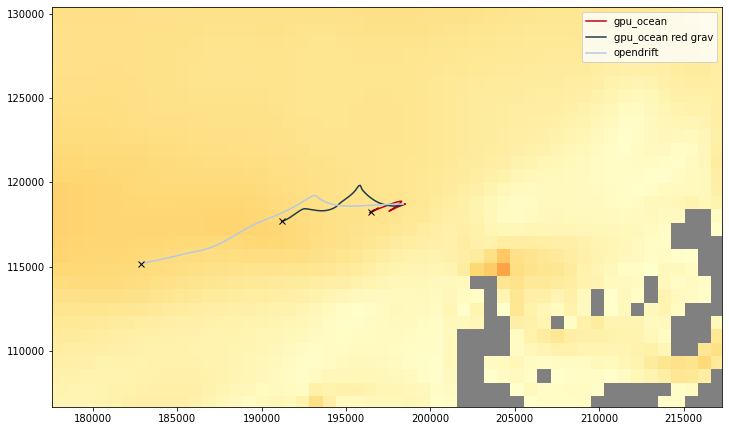

In [9]:
%matplotlib inline

#Create figure, ax with background
ax = createForecastCanvas(gpuocean_forecast,background = True, url= source_url, domain = [x0, x1, y0, y1], zoom = 10)

#Plot drifters
plotAllDrifters(gpuocean_forecast, ax= ax, color_id = 0, label = "gpu_ocean")
plotAllDrifters(gpuocean_forecast_redgrav, ax= ax, color_id = 2, label = "gpu_ocean red grav")
plotAllDrifters(opendrift_forecast_gpu, ax = ax, color_id = 1, label = "opendrift")
ax.legend()